In [1]:
import os
from WindPy import w
from datetime import *
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')
import numpy as np
import seaborn as sns
import talib
from mpl_toolkits.axes_grid1 import host_subplot
import statsmodels.formula.api as smf

# 数据读取与储存

In [2]:
def read_save_data(code="000300.SH", begin_date="2002-01-01"):
    if os.path.exists("data/%s.xlsx"%code):
        day_data = pd.read_excel("data/%s.xlsx"%code, sheet_name="Daily", index_col=0, date_parser=True)
        week_data = pd.read_excel("data/%s.xlsx"%code, sheet_name="Weekly", index_col=0, date_parser=True)
        month_data = pd.read_excel("data/%s.xlsx"%code, sheet_name="Monthly", index_col=0, date_parser=True)
    else:
        w.start()
        end_date = date.today()
        _, day_data = w.wsd(code, "open,high,low,close", begin_date, end_date, "", usedf=True)
        _, week_data = w.wsd(code, "open,high,low,close", begin_date, end_date, "Period=W", usedf=True)
        _, month_data = w.wsd(code, "open,high,low,close",begin_date, end_date, "Period=M", usedf=True)
        day_data.dropna(how="all", inplace=True)
        week_data.dropna(how="all", inplace=True)
        month_data.dropna(how="all", inplace=True)
        with pd.ExcelWriter('data/%s.xlsx'%code) as writer:  
            day_data.to_excel(writer, sheet_name='Daily')
            week_data.to_excel(writer, sheet_name='Weekly')
            month_data.to_excel(writer, sheet_name='Monthly')
        day_data.index = pd.to_datetime(day_data.index)
        week_data.index = pd.to_datetime(week_data.index)
        month_data.index = pd.to_datetime(month_data.index)
    return day_data, week_data, month_data

In [3]:
ticker = "USDCNY.IB"
frequent_dict = {"daily":252, "weekly":52, "monthly":12}
daily_price, weekly_price, monthly_price = read_save_data(ticker, begin_date="2015-08-13")
data_dict = {"daily":daily_price, "weekly":weekly_price, "monthly":monthly_price}

# 检验趋势策略是否可行
## 检验趋势持续性

In [4]:
def sustainability_plot(prices, name):
    t_value = pd.DataFrame(index=range(1, 30), columns=data_dict.keys())
    for i in prices:
        data = prices[i]
        for lag in range(1, 30):
            overall = pd.DataFrame({"x":data["CLOSE"].pct_change().shift(lag), "y":data["CLOSE"].pct_change()})
            model = smf.ols("y~x", data=overall)
            result = model.fit()
            t_value.loc[lag, i] = result.tvalues["x"]
    t_value.plot.bar(figsize=(20, 8))
    plt.title("%s lag t value"%name)
    plt.savefig("./img/%s lag t value.png"%name)

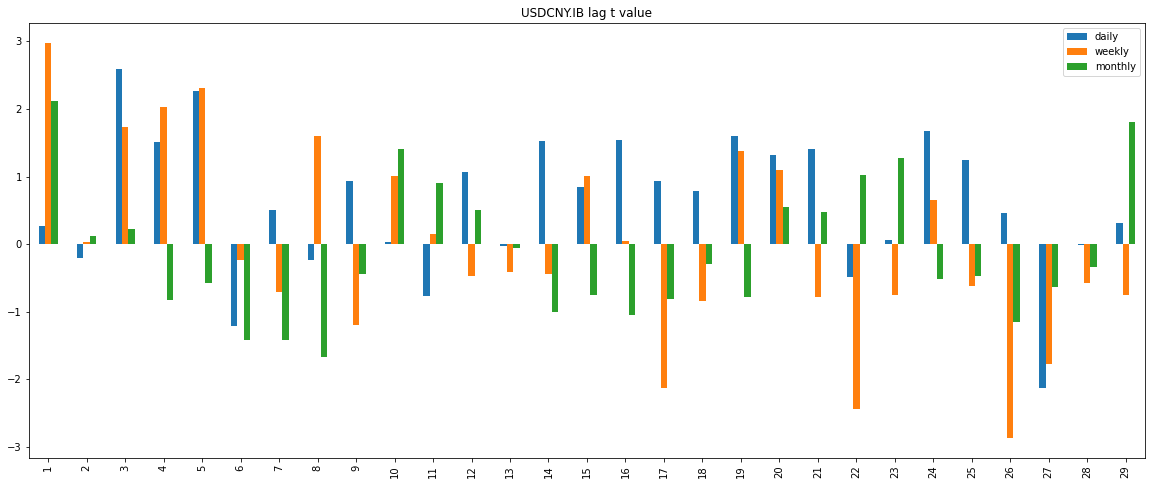

In [5]:
sustainability_plot(data_dict, ticker)

# 动量策略
## 纯动量策略（多周期加成）

In [6]:
def TSMOM(prices, name, periods):
    plt.figure(figsize=(20, 8))
    plt.title("%s TSMOM"%name)
    volatility = prices["daily"]["CLOSE"].pct_change().ewm(com=63).std()*np.sqrt(252)
    for index in periods:
        price = prices[index]
        cycle = [1, 4, 12]
        roll_windows = [round(frequent_dict[index]/i) for i in cycle]
        # momentum_list = [np.power(price["CLOSE"].pct_change(roll_windows[x])+1, cycle[x]) - 1 for x in range(len(cycle))]
        momentum_list = [np.sign(price["CLOSE"].pct_change(roll_windows[x])) for x in range(len(cycle))]
        signal_df = pd.concat([momentum_list[i]/volatility[momentum_list[i].index] for i in range(len(roll_windows))], axis=1)
        positions = signal_df.mean(axis=1)*0.4
        profit = positions.shift(1) * price["CLOSE"].pct_change()
        sharpe = np.sqrt(frequent_dict[index])*profit.mean()/profit.std()
        (profit+1).cumprod().plot(label="%s sharp:%s"%(index, sharpe))
    price = prices["daily"]
    (price["CLOSE"]/price.ix[0, "CLOSE"]).plot(label="baseline")
    plt.legend()
    plt.savefig("./img/%s TSMOM.png"%name)

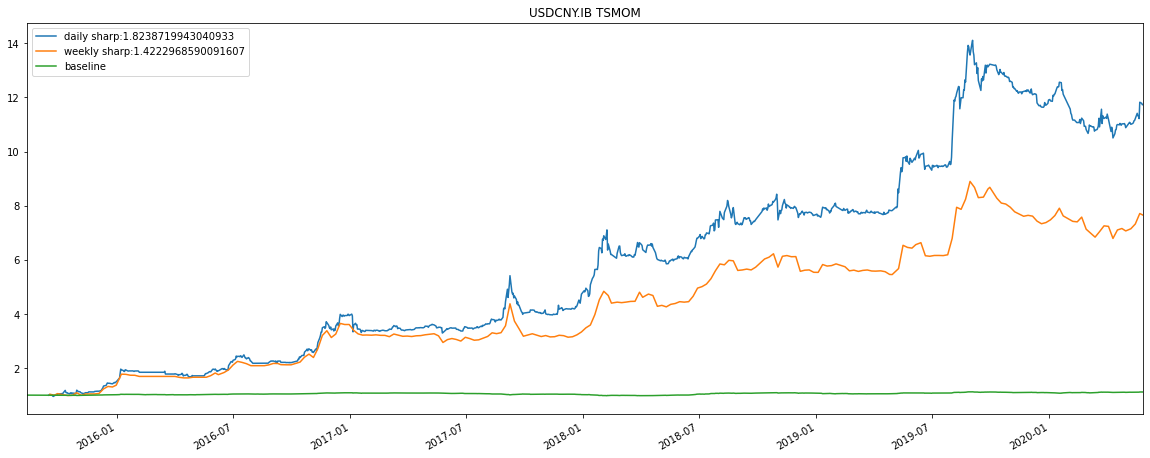

In [7]:
TSMOM(data_dict, ticker, ["daily","weekly"])

# 均线系统
## 均线类型

In [8]:
def HMA(price, n):
    return talib.WMA(2*talib.WMA(price, n/2) - talib.WMA(price, n),np.sqrt(n))

## 双均线交叉

In [9]:
def Double_cross(cross_signal, prices):
    positions = pd.Series(index=cross_signal.index)
    position = 0
    for i in range(1, len(cross_signal)):
        if position == 0:
            if cross_signal.ix[i, "diff"] > 0 and cross_signal.ix[i-1, "diff"] < 0:
                position = 1
            elif cross_signal.ix[i, "diff"] < 0 and cross_signal.ix[i-1, "diff"] > 0:
                position = -1
        elif position == 1:
            if cross_signal.ix[i, "price"] < cross_signal.ix[i, "SLOW"]:
                if cross_signal.ix[i, "diff"] < 0 and cross_signal.ix[i-1, "diff"] > 0:
                    position = -1
                else:
                    position = 0
            else:
                pass
        else:
            if cross_signal.ix[i, "price"] > cross_signal.ix[i, "SLOW"]:
                if cross_signal.ix[i, "diff"] > 0 and cross_signal.ix[i-1, "diff"] < 0:
                    position = 1
                else:
                    position = 0
            else:
                pass
        positions.iloc[i] = position
    profit = positions.shift(1) * prices["CLOSE"].pct_change()
    return profit

In [10]:
def HMA_cross(prices, name, periods, cycle):
    plt.figure(figsize=(20, 8))
    plt.title("%s HMA cross"%name)
    for i in periods:
        price_data = prices[i]
        cross_signal = pd.DataFrame()
        cross_signal["price"] = price_data["CLOSE"]
        cross_signal["SLOW"] = HMA(cross_signal["price"], frequent_dict[i]/cycle)
        cross_signal["FAST"] = HMA(cross_signal["price"], frequent_dict[i]/(2*cycle))
        cross_signal["diff"] = cross_signal["FAST"] - cross_signal["SLOW"]
        cross_signal.dropna(inplace=True)
        profit = Double_cross(cross_signal, price_data)
        sharpe = np.sqrt(frequent_dict[i])*profit.mean()/profit.std()
        (profit + 1).cumprod().plot(label="%s sharp:%s"%(i, sharpe))
    price_data = prices["daily"]
    (price_data["CLOSE"]/price_data.ix[0, "CLOSE"]).plot(label="baseline")
    plt.legend()
    plt.savefig("./img/%s HMA cross.png"%name)

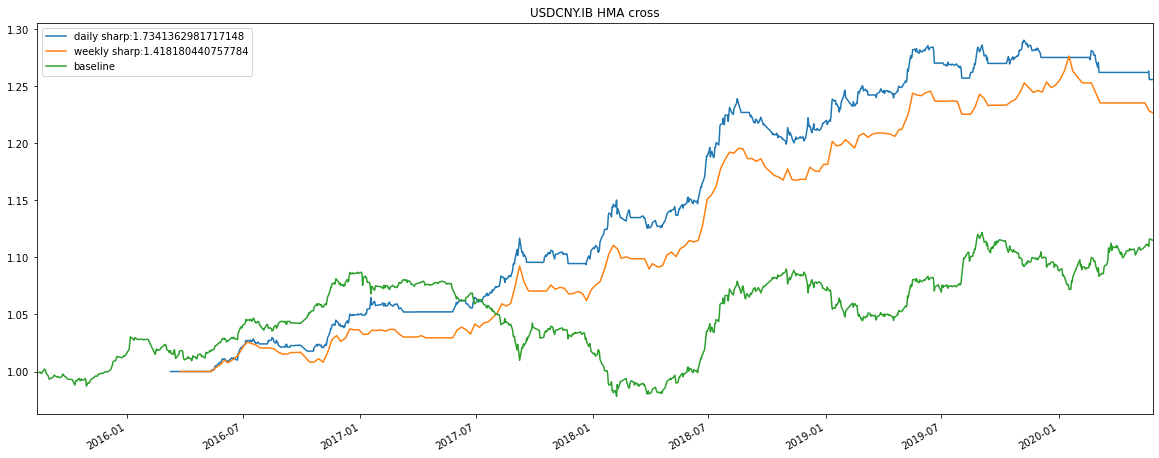

In [11]:
HMA_cross(data_dict, ticker, ["daily","weekly"], 2)

## 单均线策略

In [12]:
def MA_momentum_price(ma, price):
    position = np.sign(price["CLOSE"]-ma)
    profit = position.shift(1) * price["CLOSE"].pct_change()
    return profit

In [13]:
def HMA_momentum_price(prices, name, periods, cycle):
    plt.figure(figsize=(20, 8))
    plt.title("%s HMA momentum price"%name)
    for i in periods:
        price = prices[i]
        profit = MA_momentum_price(HMA(price["CLOSE"], frequent_dict[i]/cycle), price)
        sharpe = np.sqrt(frequent_dict[i])*profit.mean()/profit.std()
        (profit + 1).cumprod().plot(label="%s sharp:%s"%(i, sharpe))
    price = prices["daily"]
    (price["CLOSE"]/price.ix[0, "CLOSE"]).plot(label="baseline")
    plt.legend()
    plt.savefig("./img/%s HMA momentum price.png"%name)

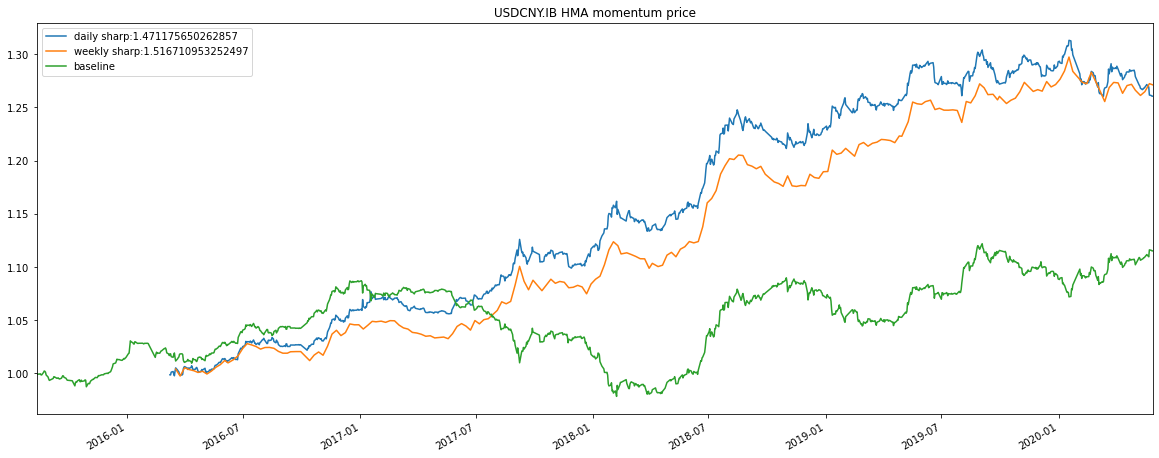

In [14]:
HMA_momentum_price(data_dict, ticker, ["daily", "weekly"], 2)

# 通道突破

In [15]:
def tunnel_break(tunnel, price):
    positions = pd.Series(index=tunnel.index)
    position = 0
    for i in range(1, len(tunnel)):
        if position == 0:
            if tunnel.ix[i, "price"] > tunnel.ix[i-1, "up"]:
                position = 1
            elif tunnel.ix[i, "price"] < tunnel.ix[i-1, "down"]:
                position = -1
        elif position == 1:
            if tunnel.ix[i, "price"] < tunnel.ix[i-1, "stop_down"]:
                if tunnel.ix[i, "price"] < tunnel.ix[i-1, "down"]:
                    position = -1
                else:
                    position = 0
            else:
                pass
        else:
            if tunnel.ix[i, "price"] > tunnel.ix[i-1, "stop_up"]:
                if tunnel.ix[i, "price"] > tunnel.ix[i-1, "up"]:
                    position = 1
                else:
                    position = 0
            else:
                pass
        positions.iloc[i] = position
    profit = positions.shift(1) * price["CLOSE"].pct_change()
    return profit

## Boll 带

In [16]:
def Boll(ma, price, period):
    overall = pd.DataFrame()
    overall["mid"] = ma
    overall["price"] = price["CLOSE"]
    std_df = pd.concat([(overall["price"] - overall["mid"]).ewm(halflife=round(frequent_dict[period]/4)).std()], axis=1)
    overall["std"] = std_df.mean(axis=1)
    overall["up"] = overall["mid"] + overall["std"]
    overall["down"] = overall["mid"] - overall["std"]
    overall["stop_up"] = overall["mid"]
    overall["stop_down"] = overall["mid"]
    return overall.dropna()

In [17]:
def HMA_tunnel_boll(prices, name, periods, cycle):
    plt.figure(figsize=(20, 8))
    ax0 = host_subplot(111)
    ax1 = ax0.twinx()
    plt.title("%s HMA tunnel boll"%name)
    for i in periods:
        price = prices[i]
        tunnel = Boll(HMA(price["CLOSE"], frequent_dict[i]/cycle), price, i)
        profit = tunnel_break(tunnel, price)
        sharpe = np.sqrt(frequent_dict[i])*profit.mean()/profit.std()
        (profit + 1).cumprod().plot(label="%s sharp:%s"%(i, sharpe), ax=ax0)
    price = prices["daily"]
    (price["CLOSE"]/price.ix[0, "CLOSE"]).plot(label="baseline", ax=ax0)
    ax0.legend()
    plt.savefig("./img/%s HMA tunnel boll.png"%name)

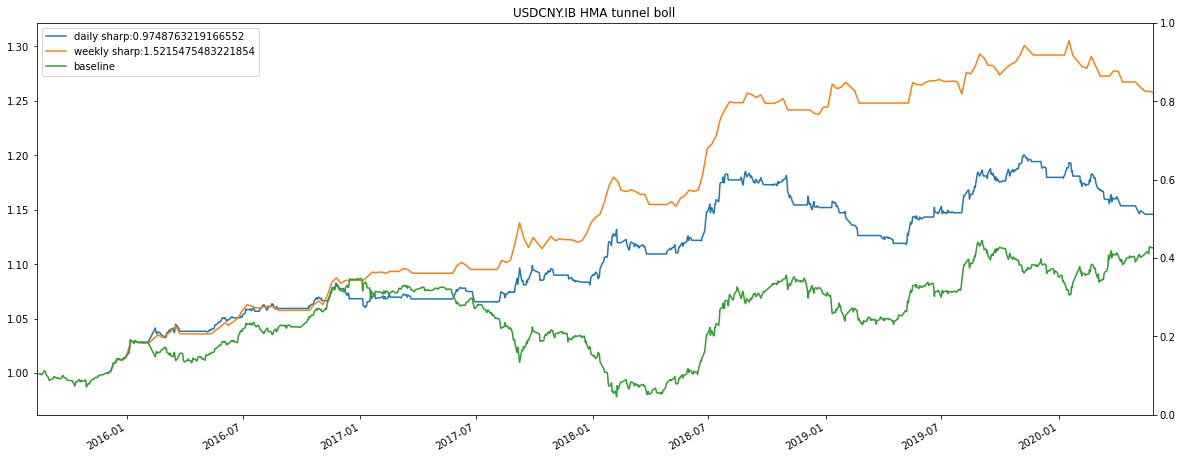

In [18]:
HMA_tunnel_boll(data_dict, ticker, ["daily", "weekly"], 4)

# 通道突破+动量策略出场

In [19]:
def tunnel_momentum(tunnel, momentum, price):
    positions = pd.Series(index=tunnel.index)
    position = 0
    for i in range(1, len(tunnel)):
        if position == 0:
            if tunnel.ix[i, "price"] > tunnel.ix[i-1, "up"]:
                position = 1
            elif tunnel.ix[i, "price"] < tunnel.ix[i-1, "down"]:
                position = -1
        elif position == 1:
            if momentum.iloc[i] < 0:
                if tunnel.ix[i, "price"] < tunnel.ix[i-1, "down"]:
                    position = -1
                else:
                    position = 0
            else:
                pass
        else:
            if momentum.iloc[i] > 0:
                if tunnel.ix[i, "price"] > tunnel.ix[i-1, "up"]:
                    position = 1
                else:
                    position = 0
            else:
                pass
        positions.iloc[i] = position
    profit = positions.shift(1) * price["CLOSE"].pct_change()
    return profit

In [20]:
def MOM(price, index):
    roll_window = round(frequent_dict[index]/12)
    signal = np.sign(price["CLOSE"].pct_change(roll_window))
    return signal
def MA_cross(price, i, cycle):
    cross_signal = pd.DataFrame()
    cross_signal["price"] = price["CLOSE"]
    cross_signal["SLOW"] = HMA(cross_signal["price"], frequent_dict[i]/cycle)
    cross_signal["FAST"] = HMA(cross_signal["price"], frequent_dict[i]/(2*cycle))
    cross_signal["diff"] = cross_signal["FAST"] - cross_signal["SLOW"]
    cross_signal.dropna(inplace=True)
    return cross_signal["diff"]

In [21]:
def HMA_tunnel_MOM(prices, name, periods, cycle):
    plt.figure(figsize=(20, 8))
    plt.title("%s HMA tunnel momentum"%name)
    for i in periods:
        price = prices[i]
        tunnel = Boll(HMA(price["CLOSE"], frequent_dict[i]/cycle), price, i)
        momentum = MOM(price, i)
        profit = tunnel_momentum(tunnel, momentum, price)
        sharpe = np.sqrt(frequent_dict[i])*profit.mean()/profit.std()
        (profit + 1).cumprod().plot(label="%s sharp:%s"%(i, sharpe))
    price = prices["daily"]
    (price["CLOSE"]/price.ix[0, "CLOSE"]).plot(label="baseline")
    plt.legend()
    plt.savefig("./img/%s HMA tunnel MOM.png"%name)

In [22]:
def HMA_tunnel_MACROSS(prices, name, periods, cycle):
    plt.figure(figsize=(20, 8))
    ax0 = host_subplot(111)
    ax1 = ax0.twinx()
    plt.title("%s HMA tunnel MA cross"%name)
    for i in periods:
        price = prices[i]
        tunnel = Boll(HMA(price["CLOSE"], frequent_dict[i]/cycle), price, i)
        momentum = MA_cross(price, i, cycle)
        profit = tunnel_momentum(tunnel, momentum, price)
        sharpe = np.sqrt(frequent_dict[i])*profit.mean()/profit.std()
        (profit + 1).cumprod().plot(label="%s sharp:%s"%(i, sharpe), ax=ax0)
    price = prices["daily"]
    (price["CLOSE"]/price.ix[0, "CLOSE"]).plot(label="baseline", ax=ax0)
    ax0.legend()
    plt.savefig("./img/%s HMA tunnel MACROSS.png"%name)

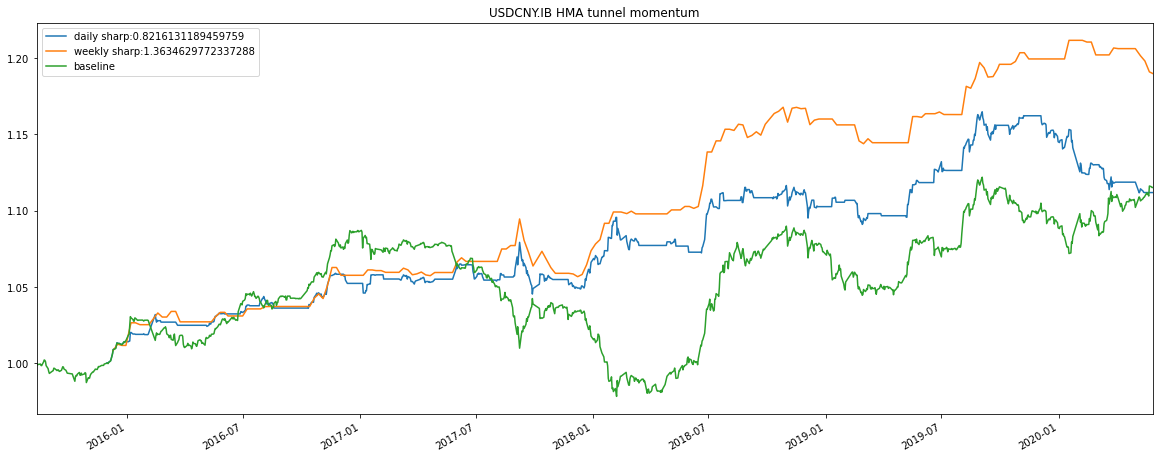

In [23]:
HMA_tunnel_MOM(data_dict, ticker, ["daily", "weekly"], 4)

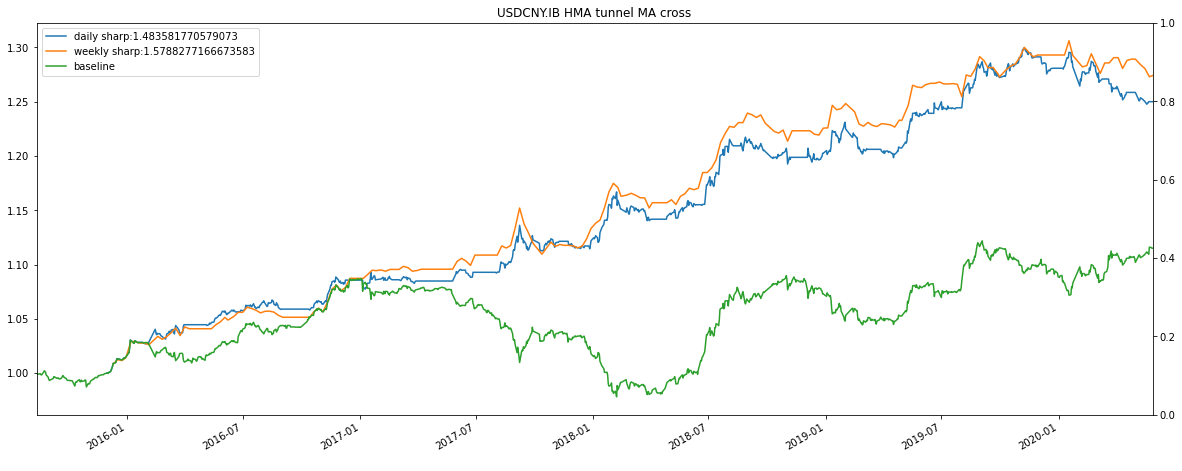

In [24]:
HMA_tunnel_MACROSS(data_dict, ticker, ["daily", "weekly"], 4)